# **Final exam - Laplace Redux**

## Implementing Bayesian Deep Learning with Laplace Approximations

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from laplace import Laplace
from sklearn.metrics import accuracy_score

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


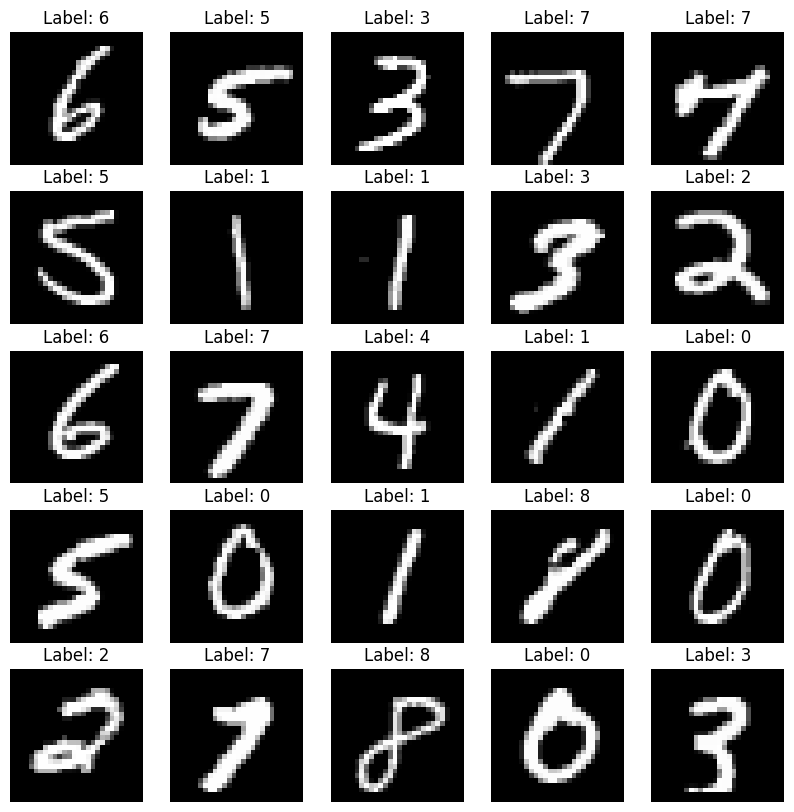

In [32]:
# View some images
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In [16]:
# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train the model
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


In [17]:
# Initialize the model, loss function and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, train_loader, criterion, optimizer)


Epoch 1/5, Loss: 0.1048758327960968
Epoch 2/5, Loss: 0.17543913424015045
Epoch 3/5, Loss: 0.07793167978525162
Epoch 4/5, Loss: 0.32407429814338684
Epoch 5/5, Loss: 0.008114526979625225


In [18]:
# Wrap the trained model with Laplace
la = Laplace(model, 'classification', subset_of_weights='last_layer', hessian_structure='diag')

# Use the training data to fit the Laplace approximation
la.fit(train_loader)

In [22]:
# Function to evaluate the Laplace-approximated model
def evaluate_laplace(la, test_loader):
    la.model.eval()  # Put the original model in evaluation mode
    all_preds = []
    all_targets = []
    device = next(la.model.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = la(data)  # Use the Laplace object for prediction
            _, predicted = torch.max(output, 1)
            all_preds.append(predicted.cpu())
            all_targets.append(target.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    accuracy = accuracy_score(all_targets, all_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Load test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Evaluate the Laplace-approximated model
evaluate_laplace(la, test_loader)


Accuracy: 96.40%


In [25]:
def predict_with_uncertainty(la, data_loader, n_samples=100):
    la.model.eval()
    all_mean_preds = []
    all_var_preds = []
    device = next(la.model.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            samples = la.predictive_samples(data, n_samples=n_samples)
            mean_preds = samples.mean(0)
            var_preds = samples.var(0)
            all_mean_preds.append(mean_preds.cpu())
            all_var_preds.append(var_preds.cpu())

    mean_preds = torch.cat(all_mean_preds)
    var_preds = torch.cat(all_var_preds)
    return mean_preds, var_preds


In [26]:
# Get predictions with uncertainty
mean_preds, var_preds = predict_with_uncertainty(la, test_loader)

# Analyze predictions
print(f'Mean Predictions: {mean_preds}')
print(f'Variance of Predictions: {var_preds}')

Mean Predictions: tensor([[1.5090e-05, 1.6465e-08, 1.3127e-03,  ..., 9.9693e-01, 1.7998e-06,
         3.2857e-04],
        [2.7335e-07, 8.3876e-02, 9.1581e-01,  ..., 9.9006e-08, 6.8400e-07,
         1.0355e-09],
        [1.2762e-07, 9.9935e-01, 1.1746e-04,  ..., 4.6339e-04, 6.4528e-06,
         2.0384e-06],
        ...,
        [5.9209e-09, 4.0402e-07, 1.0357e-08,  ..., 2.9418e-05, 1.6060e-06,
         1.6603e-04],
        [1.3449e-05, 4.1402e-05, 1.4383e-07,  ..., 1.7288e-07, 1.0947e-04,
         6.0166e-07],
        [7.2821e-06, 4.0609e-08, 3.6671e-06,  ..., 7.9868e-08, 1.1544e-06,
         2.3023e-08]])
Variance of Predictions: tensor([[2.1505e-10, 2.2433e-16, 1.4950e-06,  ..., 3.7777e-06, 2.5274e-12,
         4.0342e-08],
        [1.6375e-13, 3.1456e-03, 3.1540e-03,  ..., 1.0529e-14, 4.1221e-13,
         1.2104e-18],
        [3.0815e-14, 8.4513e-08, 7.2197e-09,  ..., 5.6783e-08, 1.5371e-11,
         1.3366e-12],
        ...,
        [1.3761e-16, 1.5801e-13, 1.4157e-16,  ..., 8.5767